In [1]:
#Run once per session
%load_ext autoreload
%autoreload 2
!pip install -q fastai==2.0.14

     |████████████████████████████████| 358kB 4.6MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 


# ITL fast.ai model

In [1]:
from fastai.vision.all import *

In [4]:
VERSION=8
ITL_DS_NAME = f'itl_dataset_v{VERSION}.zip'
ITL_DS_URL =  f'http://students.mimuw.edu.pl/~mt406390/machine_learning/' + ITL_DS_NAME
!wget $ITL_DS_URL
!unzip -qq $ITL_DS_NAME -d data/
path = Path('data')

In [5]:
path.ls()

(#8) [Path('data/output_black'),Path('data/output_color'),Path('data/operators.txt'),Path('data/output_bbox'),Path('data/output_proper'),Path('data/annotations.json'),Path('data/itl_labels.txt'),Path('data/config')]

In [6]:
annots = json.load(path / 'annotations.json')
# FIXME (17 bboxes missing)
annots = list(filter(lambda x: len(x['exprs']) > 0, annots))

In [7]:
images = list(x['name'] for x in annots if len(x['exprs']) > 0)
print(len(images))
images[0]

6127


'eq0.png'

In [73]:
op_lens = {'add': 2, 'sub': 2, 'mul': 2, 'frac': 2, 'sqrt': 1, 'int': 1, 'par': 1, 'fpar': 1, 'ffpar': 1, 'gpar': 1}

Next, we want to be able to quickly look up a corresponding image to it's label. We'll use a dictionary

In [8]:
img2bbox = dict(zip(images, annots))

Let's check the first item

Great! Now let's build our `DataBlock`. We'll have two outputs, the bounding box itself and a label, with one input. For our `y`'s, we'll define some `getters`. The first of which will be `noop`, as we don't care about our initial image, and then we'll grab our label and bbox coordinates (we'll also define our `get_items`)

In [9]:
def bbox_to_fastai(box):
    x, y, dx, dy = box
    return [x, y, x + dx, y + dy]

getters = [
    lambda o: path/'output_proper'/o, lambda o: list(map(bbox_to_fastai, img2bbox[o]['exprs'])),
    lambda o: len(img2bbox[o]['exprs']) * [img2bbox[o]['op']]
]

For our transforms, we'll use some of the ones we defined earlier

In [10]:
item_tfms = []
batch_tfms = [Zoom(0.8, 1.2), Warp(0.15), Saturation(max_lighting=0.5)]

Why do we need a custom `get_images`? Because we want our **images** that came back to us, not the entire folder

In [11]:
def get_train_imgs(noop):  return images

We'll now make our `DataBlock`. We want to adjust `n_inp` as we expect two outputs

In [12]:
pascal = DataBlock(blocks=(ImageBlock(cls=PILImageBW), BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs, 
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [13]:
BS = 32
dls = pascal.dataloaders(path/'train', bs=BS)
dls.c = len(set(x['op'] for x in annots))

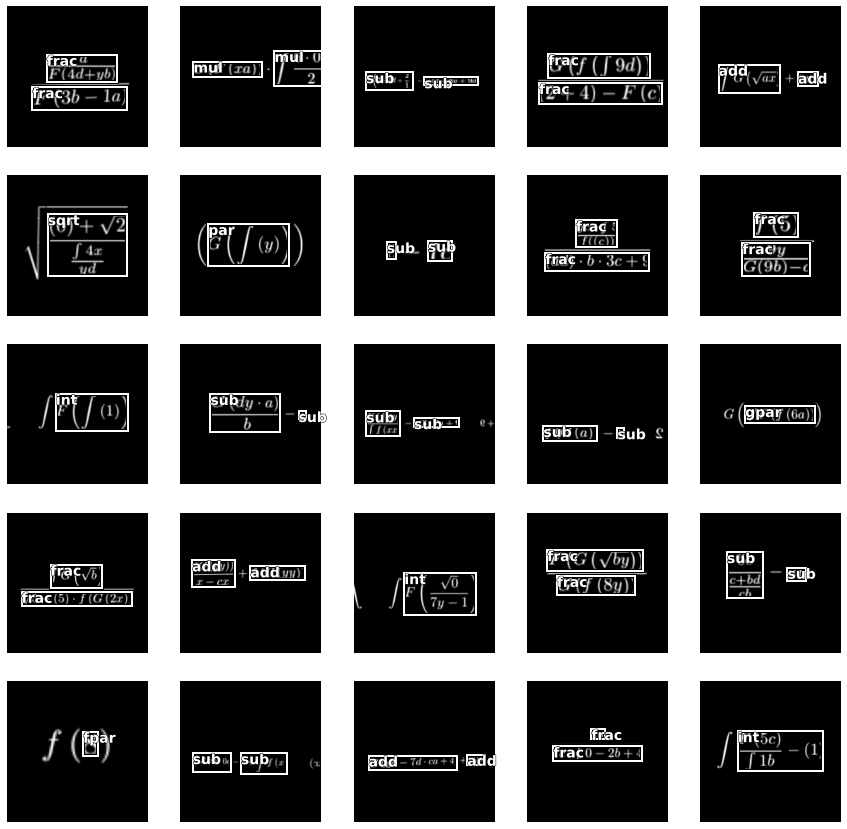

In [14]:
dls.show_batch(max_n=25)

# ITL model

In [15]:
POINTS_PER_BBOX = 4
N_BBOXES = 2
BBOXES = N_BBOXES * POINTS_PER_BBOX
CATS = dls.c
OUT = CATS + BBOXES

In [16]:
head = nn.Sequential(
    nn.Conv2d(512, 128, 3, 2),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, OUT, 3, 1),
    # nn.BatchNorm2d(OUT),
    nn.Flatten()
)

bigger_head = nn.Sequential(
    nn.Conv2d(512, 256, 3, 1),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 128, 3, 1),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, OUT, 3, 1),
    # nn.BatchNorm2d(OUT),
    nn.Flatten()
)

fc = create_head(1024, OUT)

cfg = cnn_config(n_in=1, custom_head=head)

In [85]:
from torchvision.ops import box_iou

from pdb import set_trace

class MseAndCrossEntropy(Module):
    def forward(self, pred, target_bboxes, target_cat):
        bboxes_preds = torch.sigmoid(pred[..., CATS:]).view((-1, N_BBOXES, POINTS_PER_BBOX))
        mask = (target_cat > 0)

        # set_trace()
        box_loss = F.mse_loss(bboxes_preds[mask], target_bboxes[mask], reduction='sum')
        ce_loss = F.cross_entropy(pred[..., :CATS], target_cat[..., 0] - 1)
        return ce_loss + box_loss

def ops_accuracy(pred, target_bboxes, target_cat):
    return accuracy(pred[..., :CATS], target_cat[..., 0] - 1)
    
def boxes_iou(pred, target_bboxes, target_cat):
    bboxes_preds = torch.sigmoid(pred[..., CATS:]).view((-1, N_BBOXES, POINTS_PER_BBOX))
    bboxes_preds = (2 * bboxes_preds) - 1

    mask = (target_cat > 0)
    x, y = bboxes_preds[mask], target_bboxes[mask]
    ious = torch.diagonal(box_iou(x, y))
    return ious.mean()


@log_args
class ITLLoss(BaseLoss):
    def __init__(self, *args, axis=-1, **kwargs):
        super().__init__(MseAndCrossEntropy, *args, axis=axis, **kwargs)

    def __call__(self, inp, targ, labels, **kwargs):
        targ_scaled = (1 + targ) / 2

        return self.func.__call__(inp, targ_scaled, labels)

    def decodes(self, x):
        categories, bboxes = x[...,:CATS], x[...,CATS:]
        bboxes = torch.sigmoid(bboxes)
        # Scaling back
        bboxes = 2*bboxes - 1
        bboxes = bboxes.view(-1, 2, 4)

        cats = (1 + categories.argmax(dim=-1)).unsqueeze(dim=-1)

        cats_stacked = torch.cat((cats, torch.zeros(cats.shape, dtype=torch.int64)), axis=-1)
        n = bboxes.shape[0]
        for i in range(n):
            current_cat = cats[i, 0]
            cat_lbl = dls.vocab[current_cat]
            if op_lens[cat_lbl] == 2:
                cats_stacked[i, 1] = cats_stacked[i, 0]
            else:
                bboxes[i, 1] = 0

        return bboxes, TensorMultiCategory(cats_stacked)


In [88]:
prr = learn_test.get_preds(dl=[dls.valid.one_batch()], with_decoded=True)

In [96]:
learn = cnn_learner(dls, resnet18, loss_func=ITLLoss(), pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])
learn.fit_one_cycle(40)

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,5.553633,4.143646,0.392653,0.304946,00:24
1,3.980922,3.386525,0.460408,0.331080,00:25
2,3.227258,2.711522,0.497143,0.405403,00:25
3,2.701879,2.098404,0.525714,0.430748,00:25
4,2.149180,2.229059,0.573878,0.439562,00:25
5,1.712475,2.187878,0.702041,0.400841,00:24
6,1.496530,1.780741,0.760000,0.418249,00:24
7,1.285883,11.266371,0.182857,0.255699,00:24
8,1.029143,7.151618,0.262857,0.350331,00:24
9,0.845075,8.721751,0.257959,0.329695,00:24


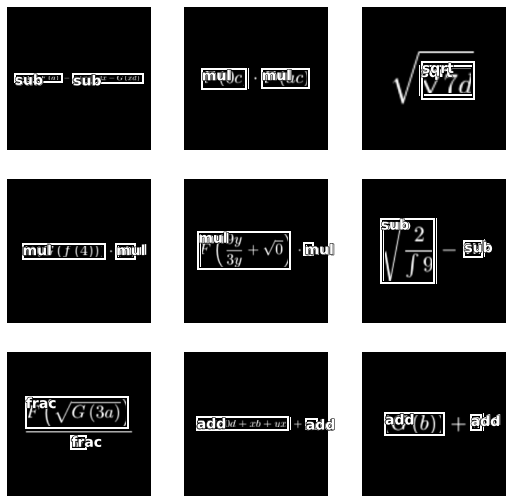

In [102]:
learn.show_results()

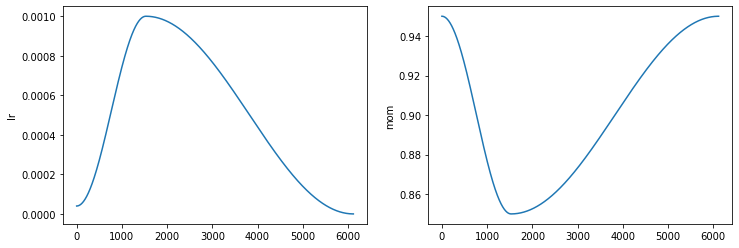

In [103]:
learn.recorder.plot_sched()

In [105]:
learn.summary()

Sequential (Input shape: ['32 x 1 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 112 x 112  3,136      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 32 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               32 x 64 x 56 x 56    36,864     True      
________________________________________________________________
BatchNorm2d          32 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 32 x 64 x 56 x 56    0          False     
_________________________________________________